In [112]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt

In [2]:
source_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'

In [3]:
genome = 'Pst_104E_v12_p_ctg'

In [4]:
out_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis'

In [5]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [6]:
#remove all commenting lines from the initial repet file
!grep -v "^#" {source_dir}/{genome}.REPET.gff > {out_dir}/{genome}.REPET.gff

In [135]:
p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

In [8]:
TE_post_analysis_p = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/REPET/Pst79_p/Pst79_p_full_annotate/postanalysis'

In [9]:
TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')

In [10]:
TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']

In [11]:
#this needs to be fixed up to pick the proper summary table
p_repet_summary_df = pd.read_csv(TE_post_analysis_p+'/'+'Pst79p_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' ,\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#check if I can filter the tab files for removing all TEs that are on the 2000 plus contigs
#remove tRNAs TEs with infernal

p_repet_summary_df['Code'] = p_repet_summary_df['TE'].apply(lambda x: x.split('_')[0])

code_keys = p_repet_summary_df['Code'].unique()

code_keys.sort()

code_long = ['DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Maverick',\
            'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon noCat',\
             'DNA_transposon MITE','DNA_transposon MITE', 'Potential Host Gene', 'Retrotransposon LINE', 'Retrotransposon LINE',\
             'Retrotransposon LINE','Retrotransposon LTR','Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon PLE', \
             'Retrotransposon SINE',  'Retrotransposon SINE', 'Retrotransposon noCat', 'Retrotransposon LARD',\
             'Retrotransposon LARD', 'Retrotransposon TRIM', 'Retrotransposon TRIM', 'Retrotransposon noCat',  \
             'Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS',\
             'noCat', 'noCat']

code_dict = dict(zip(code_keys, code_long))

In [12]:
p_repet_summary_df['Code long'] = p_repet_summary_df['Code'].apply(lambda x: code_dict[x])

p_repet_summary_sum_df = pd.pivot_table(p_repet_summary_df, values=['covg', 'copies'], index='Code long', aggfunc=np.sum)

p_repet_summary_mean_df = pd.pivot_table(p_repet_summary_df, values='length', index='Code long', aggfunc=np.mean)

pd.concat([p_repet_summary_sum_df,p_repet_summary_mean_df], axis=1 )

,copies,covg,length
Code long,,,
DNA_transposon Helitron,1075,817566,2989.764706
DNA_transposon MITE,3789,886304,490.240741
DNA_transposon Maverick,268,345406,8562.666667
DNA_transposon TIR,19166,12711595,4020.474359
DNA_transposon noCat,5286,2376456,3034.734513
Potential Host Gene,1372,1375304,6120.490566
Retrotransposon DIRS,1337,1049299,6874.526316
Retrotransposon LARD,10752,4947564,5407.736111
Retrotransposon LINE,323,237992,4446.625000


In [132]:
#pull out the top 20 TEs based on coverage in the coverage dataframe
p_repet_top_20 = p_repet_summary_df[~(p_repet_summary_df['Code']=='PotentialHostGene')].sort_values(by='covg', ascending=False).reset_index(drop=True).iloc[0:20,:]

In [139]:
p_repet_top_20.head()

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,maxLgth,meanLgthPerc,sdLgthPerc,minLgthPerc,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,Code,Code long
0,DXX_MCL2_Pst79_REPET-B-G1715-Map3,18812,335432,225,3,187,3,87.87,10.61,59.80,...,18818.0,9.54,20.96,0.11,0.48,1.66,6.02,100.03,DXX,DNA_transposon noCat
1,DTX-incomp_MCL9_Pst79_REPET-B-G1698-Map4_reversed,13182,333753,419,7,356,8,80.27,9.44,59.00,...,13264.0,7.12,18.65,0.16,0.59,1.43,5.48,100.62,DTX-incomp,DNA_transposon TIR
2,DXX_MCL287_Pst79_REPET-B-R3576-Map14,28094,175364,147,1,125,1,79.67,9.67,55.40,...,28085.0,5.04,13.43,0.07,0.24,0.59,1.61,99.97,DXX,DNA_transposon noCat
3,noCat_MCL102_Pst79_REPET-B-R139-Map11,12696,171929,77,5,63,5,75.30,16.61,55.30,...,12857.0,21.50,28.14,0.17,1.24,12.53,28.64,101.27,noCat,noCat
4,RLX-comp_MCL8_Pst79_REPET-B-P528.25-Map3,9453,152539,56,9,41,10,91.29,9.88,67.35,...,9901.0,39.37,41.85,0.39,2.36,14.18,92.03,104.74,RLX-comp,Retrotransposon LTR


In [140]:
p_repet_top_20_TE = p_repet_top_20['TE']

In [143]:
['_'.join(x.split('_')[:2]) for x in p_repet_top_20_TE]

['DXX_MCL2',
 'DTX-incomp_MCL9',
 'DXX_MCL287',
 'noCat_MCL102',
 'RLX-comp_MCL8',
 'DTX-incomp_MCL78',
 'DTX-incomp_MCL75',
 'RLX-incomp_MCL10',
 'DTX-comp_MCL40',
 'RLX-incomp-chim_MCL20',
 'DTX-incomp_MCL16',
 'RLX-incomp_MCL2',
 'DTX-incomp-chim_MCL2',
 'RXX-LARD-chim_MCL69',
 'RLX-comp_MCL39',
 'RYX-comp-chim_MCL293',
 'RLX-incomp_MCL81',
 'RLX-comp_MCL215',
 'DTX-incomp_MCL38',
 'RLX-incomp_MCL18']

In [13]:
#now filter the gff dataframe to delete all the high coverage contigs
#This might would have to be fixed as well. If we don't delete it as files should be already filtered
contigs_smaller_2000 = pd.read_csv('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly/pcontig_smaller_2000.txt',\
                                  header=None)[0].tolist()

In [136]:
p_repet_gff_filtered = p_repet_gff[p_repet_gff[0].isin(contigs_smaller_2000)].reset_index(drop=True)

In [15]:
def ID_filter_gff(_feature, _id):
    """
    This filter parses out the top level id form the 9th gff column form a REPET gff file.
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':

        TE_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9,-]*)_'
        TE_prog = re.compile(TE_pattern)
        TE_match = TE_prog.search(_id)
        return TE_match.group(1)
    if _type == 'REPET_SSRs':
        
        SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        SSR_prog = re.compile(SSR_pattern)
        SSR_match = SSR_prog.search(_id)
        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        #if "#" in _id:
        #     blast_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*[_]?[A-Z,a-z,0-9,-]*[_|#|0-9]+?:[A-Z,a-z,0-9,-,:]*)'
        #else:
        #    blast_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([\w+|:|-]*)'
        blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)')
        #blast_prog = re.compile(blast_pattern)
        blast_match = blast_prog.search(_id)
        return blast_match.group(1)


In [137]:
p_repet_gff_filtered['ID'] = p_repet_gff_filtered.apply(lambda row: ID_filter_gff(row[1], row[8]), axis=1)

In [138]:
#filter out potential host genes
p_repet_gff_filtered = p_repet_gff_filtered[~p_repet_gff_filtered[8].str.contains("Potential")]

In [141]:
p_repet_gff_filtered.head()

,0,1,2,3,4,5,6,7,8,ID
0,pcontig_193,Pst79p_anno_REPET_TEs,match,54973,55495,0.0,-,.,ID=ms7308_pcontig_193_DTX-incomp-chim_MCL5_Pst...,DTX-incomp-chim_MCL5
1,pcontig_193,Pst79p_anno_REPET_TEs,match_part,54973,55495,0.0,-,.,ID=mp7308-1_pcontig_193_DTX-incomp-chim_MCL5_P...,DTX-incomp-chim_MCL5
2,pcontig_193,Pst79p_anno_REPET_TEs,match,359,1264,0.0,-,.,ID=ms7309_pcontig_193_DTX-incomp_MCL9_Pst79_RE...,DTX-incomp_MCL9
3,pcontig_193,Pst79p_anno_REPET_TEs,match_part,359,1264,0.0,-,.,ID=mp7309-1_pcontig_193_DTX-incomp_MCL9_Pst79_...,DTX-incomp_MCL9
4,pcontig_193,Pst79p_anno_REPET_TEs,match,1430,3581,0.0,-,.,ID=ms7310_pcontig_193_DTX-incomp_MCL9_Pst79_RE...,DTX-incomp_MCL9


In [147]:
p_repet_gff_2 = p_repet_gff_filtered.loc[:,:]

In [148]:
p_repet_gff_2.drop_duplicates(subset=[3,5,'ID'], inplace=True)

In [150]:
p_repet_gff_2['Length'] = p_repet_gff_2[4] - p_repet_gff_2[3]

In [151]:
p_repet_gff_len = p_repet_gff_2.groupby('ID')['Length'].sum()

In [161]:
p_repet_gff_len.sort_values(ascending=False)[:20]

ID
hAT-5_PSt:ClassII:TIR:hAT             1143889
Academ-1_PGr:ClassII:?:Academ          872967
Gypsy-17_PGr-I_1p:ClassI:LTR:Gypsy     509470
Gypsy-17_PGr-I:ClassI:LTR:Gypsy        467152
hAT-8_PGr:ClassII:TIR:hAT              466774
RLX-incomp_MCL2                        427055
Academ-1_PGr_1p:ClassII:?:Academ       422204
Academ-1_PGr_2p:ClassII:?:Academ       420384
LTR-3_PSt-LTR:ClassI:LTR:?             419063
RLX-incomp_MCL10                       413336
Gypsy-19_PGr-I:ClassI:LTR:Gypsy        410923
DTX-incomp_MCL9                        406598
DXX_MCL2                               368749
Gypsy-19_PGr-I_2p:ClassI:LTR:Gypsy     365840
Gypsy-12_PGr-I:ClassI:LTR:Gypsy        361278
DNA-9_PSt:ClassII:?:?                  351613
Gypsy-3_PSt-I:ClassI:LTR:Gypsy         349446
Gypsy-22_PGr-I_1p:ClassI:LTR:Gypsy     348956
MuDR-3_PGr_1p:ClassII:TIR:MuDR         344261
Gypsy-7_PSt-I:ClassI:LTR:Gypsy         333505
Name: Length, dtype: int64

In [18]:
num_unique_REs = len(p_repet_gff_filtered['ID'].unique())

In [19]:
print('This is the number of unique repetitive elements: %i' % num_unique_REs)

This is the number of unique repetitive elements: 48659


In [20]:
frequency_of_REs  = p_repet_gff_filtered.groupby('ID')[0].count()

In [21]:
frequency_of_REs.sort_values(inplace=True)

In [22]:
p_repet_gff_filtered.to_csv(out_dir+'/'+genome+'.REPET.filtered.gff', sep='\t', header = None, index=None,columns=None)

In [23]:
p_repet_gff_filtered[8] = p_repet_gff_filtered['ID']

In [24]:
p_repet_gff_filtered_2 = p_repet_gff_filtered.iloc[:,0:9]

In [25]:
p_repet_gff_filtered_2.to_csv(out_dir+'/'+genome+'.REPET.ID_column.gff', sep='\t', header = None, index=None,columns=None)

In [26]:
#have another dataframe that only contains the REPET denovo annotation and not blast hits
#repet_gff_filtered_TEs = p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')]

In [27]:
#get all the 'Code' phrases blast hits and make a blast_code_dict
#this needs to get the subsetting filters set for different dataframes

blast_codes = p_repet_gff_filtered_2[(p_repet_gff_filtered_2[1]=='Pst79p_anno_REPET_tblastx') | (p_repet_gff_filtered_2[1]=='Pst79p_anno_REPET_blastx')][8]

blast_codes_list = [ ':'.join(x.split(':')[1:-1]) for x in blast_codes.unique()]

blast_codes_list_unique = list(set(blast_codes_list))

blast_codes_list_unique.sort()

blast_codes_list_unique

blast_code_long = ['Retrotransposon noCat', 'Retrotransposon DIRS', 'Retrotransposon LINE', 'Retrotransposon LTR', 'Retrotransposon PLE','DNA_transposon noCat',\
                   'DNA_transposon Crypton','DNA_transposon Helitron','DNA_transposon Maverick','DNA_transposon TIR']

blast_code_dict = dict(zip(blast_codes_list_unique, blast_code_long))


In [120]:
blast_codes_list_subclass = [ ':'.join(x.split(':')[1:]) for x in blast_codes.unique()]

In [ ]:
#make a dataframe with only the blast hits as occurance and use this to generate a coverage plot.

In [134]:
p_repet_gff_filtered.head()

,0,1,2,3,4,5,6,7,8,ID
0,pcontig_193,Pst79p_anno_REPET_TEs,match,54973,55495,0.0,-,.,DTX-incomp-chim_MCL5,DTX-incomp-chim_MCL5
1,pcontig_193,Pst79p_anno_REPET_TEs,match_part,54973,55495,0.0,-,.,DTX-incomp-chim_MCL5,DTX-incomp-chim_MCL5
2,pcontig_193,Pst79p_anno_REPET_TEs,match,359,1264,0.0,-,.,DTX-incomp_MCL9,DTX-incomp_MCL9
3,pcontig_193,Pst79p_anno_REPET_TEs,match_part,359,1264,0.0,-,.,DTX-incomp_MCL9,DTX-incomp_MCL9
4,pcontig_193,Pst79p_anno_REPET_TEs,match,1430,3581,0.0,-,.,DTX-incomp_MCL9,DTX-incomp_MCL9


In [28]:
blast_code_dict

{'ClassI:?': 'Retrotransposon noCat',
 'ClassI:DIRS': 'Retrotransposon DIRS',
 'ClassI:LINE': 'Retrotransposon LINE',
 'ClassI:LTR': 'Retrotransposon LTR',
 'ClassI:PLE': 'Retrotransposon PLE',
 'ClassII:?': 'DNA_transposon noCat',
 'ClassII:Crypton': 'DNA_transposon Crypton',
 'ClassII:Helitron': 'DNA_transposon Helitron',
 'ClassII:Maverick': 'DNA_transposon Maverick',
 'ClassII:TIR': 'DNA_transposon TIR'}

In [29]:
#write a filer function that adds a 'code long'

In [30]:
def code_long_filter_gff(_feature, _id):
    """
    This filter parses out Order and class of the TE based on Wicker et al. using the previously generated ID column. 
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        #split the 
        code = _id.split('_')[0]
        return code_dict[code]
    if _type == 'REPET_SSRs':
        return 'SSR'
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        code = ':'.join(_id.split(':')[1:-1])
        return blast_code_dict[code]

In [31]:
p_repet_gff_filtered_2['Classification'] = p_repet_gff_filtered_2.apply(lambda row: code_long_filter_gff(row[1], row[8]), axis=1)

In [32]:
p_repet_gff_filtered_2["Classification"].unique()

array(['DNA_transposon TIR', 'Retrotransposon DIRS', 'Retrotransposon LTR',
       'SSR', 'DNA_transposon noCat', 'DNA_transposon MITE',
       'Retrotransposon LARD', 'Retrotransposon SINE', 'noCat',
       'DNA_transposon Helitron', 'DNA_transposon Maverick',
       'Retrotransposon LINE', 'Retrotransposon TRIM',
       'Retrotransposon noCat', 'Retrotransposon PLE',
       'DNA_transposon Crypton'], dtype=object)

In [33]:
#in the .classificaiton gff the feature column 2 is the Wicker classification of the transposon
p_repet_gff_filtered_2[8] = p_repet_gff_filtered_2['Classification'] 
#repet_gff_filtered_TEs[1] = repet_gff_filtered_TEs["Classification"]

In [34]:
p_repet_gff_filtered_2.iloc[:,:-1].to_csv(out_dir+'/'+genome+'.REPET.classification.gff', sep='\t', header = None, index=None,columns=None)

In [35]:
#save the no_blast hit REPET gff as well.
p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')].iloc[:,:-1].to_csv(out_dir+'/'+genome+'.REPET_noblast.classification.gff', sep='\t', header = None, index=None,columns=None)

In [118]:
#save the no_blast hit REPET gff as well.
p_repet_gff_filtered_2[p_repet_gff_filtered_2[1].str.contains('blast')].iloc[:,:-1].to_csv(out_dir+'/'+genome+'.REPET_blast.classification.gff', sep='\t', header = None, index=None,columns=None)

In [36]:
#write a similar filter as before using bedtools to move through all the classifications and caclulate coverage
#summarize this in a table and compare to published stuff

In [37]:
#generate the directory structure to safe specific coverage files
os.chdir(out_dir)
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [38]:
repet_prefix = genome+'.REPET.classification'
p_genome_file = genome+'.genome_file'

In [39]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter_classification(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [49]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id_classification(_id, bed_object):
    #retrotransposon 
    if 'Retrotransposon' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #DNA_transponson
    elif 'DNA_transposon' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #notCat 
    elif 'noCat' in _id:
        out_path = TE_path_dict['noCat']
    #SSR
    elif 'SSR' in _id:
        out_path = TE_path_dict['SSR']
    repet_prefix = genome+ '.'+bed_object.fn.split('.')[-3] + '.classification'
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    out_fn= out_fn.replace(" ", '_')
    result = bed_object.filter(id_filter_classification, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    print("Done with %s using %s as bedfile " % (out_fn.split('/')[-1], bed_object.fn.split('/')[-1]))
    #return pybedtools.BedTool(result.fn)

In [41]:
#pull in the classification gff, make classification array, loop over array to save all the cov_dataframes
RE_id_gff = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.classification.gff')
g = RE_id_gff.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.classification.bedobject')
#use the blast filtered dataframe as well
RE_id_gff_noblast = pybedtools.BedTool(out_dir+'/'+genome+'.REPET_noblast.classification.gff')
g_noblast = RE_id_gff_noblast.remove_invalid().saveas(out_dir+'/'+genome+'.REPET_noblast.classification.bedobject')

In [119]:
#use the blast filtered dataframe as well
RE_id_gff_blast = pybedtools.BedTool(out_dir+'/'+genome+'.REPET_blast.classification.gff')
g_blast = RE_id_gff_blast.remove_invalid().saveas(out_dir+'/'+genome+'.REPET_blast.classification.bedobject')

In [42]:
#filter through the whole REPET_TE bedobject
#maybe make some multiproccesses out of this
classifications = p_repet_gff_filtered_2["Classification"].unique()
#[subset_id_classification(x, g) for x in classifications]

In [43]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
bed_file = g
for classi in classifications:
    p = multiprocessing.Process(target=subset_id_classification, args=(classi, bed_file,))
    jobs.append(p)
    p.start()
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done!")

Process-1.exitcode = None
Process-2.exitcode = None
Process-3.exitcode = None
Process-4.exitcode = None
Process-5.exitcode = None
Process-6.exitcode = None
Process-7.exitcode = None
Process-8.exitcode = None
Process-9.exitcode = None
Process-10.exitcode = None
Process-11.exitcode = None
Process-12.exitcode = None
Process-13.exitcode = None
Process-14.exitcode = None
Process-15.exitcode = None
Process-16.exitcode = None
Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_SINE.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.DNA_transposon_Crypton.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_PLE.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_noCat.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Don

In [55]:
#generate a coverage file for each genome position from the gff without filtering for specific features
all_cov_RE = g.genome_coverage(dz=True,g=p_genome_file)
all_cov_RE.saveas('Pst_104E_v12_p_ctg.REPET.classification.cov')

<BedTool(Pst_104E_v12_p_ctg.REPET.classification.cov)>

In [44]:
#print out the exitcodes for each
for j in jobs:
    #j.join()
    print('%s.exitcode = %s' % (j.name, j.exitcode))

Process-1.exitcode = 0
Process-2.exitcode = 0
Process-3.exitcode = 0
Process-4.exitcode = 0
Process-5.exitcode = 0
Process-6.exitcode = 0
Process-7.exitcode = 0
Process-8.exitcode = 0
Process-9.exitcode = 0
Process-10.exitcode = 0
Process-11.exitcode = 0
Process-12.exitcode = 0
Process-13.exitcode = 0
Process-14.exitcode = 0
Process-15.exitcode = 0
Process-16.exitcode = 0


In [50]:
#filter through the whole REPET_TE bedobject having removed the blast hits
#maybe make some multiproccesses out of this
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
classifications_noblast = p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')]["Classification"].unique()
classifications = classifications_noblast
bed_file = g_noblast
for classi in classifications:
    p = multiprocessing.Process(target=subset_id_classification, args=(classi, bed_file,))
    jobs.append(p)
    p.start()
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done!")
#print out the exitcodes for each
for j in jobs:
    #j.join()
    print('%s.exitcode = %s' % (j.name, j.exitcode))

Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_PLE.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_SINE.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_noCat.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_TRIM.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_LINE.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.DNA_transposon_Maverick.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Waiting for Subset_id_classification to fin

In [51]:
cur_dir = os.path.abspath(os.path.curdir)

In [52]:
genome_df = pd.read_csv(p_genome_file, sep='\t', header=None,names=['contig', 'length'])

genome_size = genome_df['length'].sum()

In [53]:
#this caputures all REPET classifications including blast and internal REPET_TEs
#the problem found here is that the blast and the REPET annotation is sometimes contratictory and overlapping
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir):
    #print(dirpath)
    #print(len(filenames))
    if len(filenames) == 0:  # empty folder
        continue
    cov_files = [dirpath +'/'+x for x in filenames if x.endswith('.cov') and 'REPET.classification' in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_classification = pd.concat(df_list)

cov_per_class = df_REPET_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class = df_REPET_classification.groupby([0, 'Code long'])[1].count()

DNA_transposon_Crypton
DNA_transposon_Helitron
DNA_transposon_MITE
DNA_transposon_Maverick
DNA_transposon_TIR
DNA_transposon_noCat
Retrotransposon_DIRS
Retrotransposon_LARD
Retrotransposon_LINE
Retrotransposon_LTR
Retrotransposon_PLE
Retrotransposon_SINE
Retrotransposon_TRIM
Retrotransposon_noCat
SSR
noCat


In [54]:
#this caputures all REPET classifications including internal REPET_TEs classification only. No blast hits included
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir):
    #print(dirpath)
    #print(len(filenames))
    if len(filenames) == 0:  # empty folder
        continue
    cov_files = [dirpath +'/'+x for x in filenames if x.endswith('.cov') and 'REPET_noblast.classification' in x ]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_noblast_classification = pd.concat(df_list)

cov_per_class_noblast = df_REPET_noblast_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class_noblast = df_REPET_noblast_classification.groupby([0, 'Code long'])[1].count()

DNA_transposon_Helitron
DNA_transposon_MITE
DNA_transposon_Maverick
DNA_transposon_TIR
DNA_transposon_noCat
Retrotransposon_DIRS
Retrotransposon_LARD
Retrotransposon_LINE
Retrotransposon_LTR
Retrotransposon_PLE
Retrotransposon_SINE
Retrotransposon_TRIM
Retrotransposon_noCat
SSR
noCat


In [56]:
cov_per_class/genome_size

Code long
DNA_transposon_Crypton     0.000015
DNA_transposon_Helitron    0.014380
DNA_transposon_MITE        0.012342
DNA_transposon_Maverick    0.004510
DNA_transposon_TIR         0.180167
DNA_transposon_noCat       0.055862
Retrotransposon_DIRS       0.015830
Retrotransposon_LARD       0.066880
Retrotransposon_LINE       0.004594
Retrotransposon_LTR        0.258021
Retrotransposon_PLE        0.000692
Retrotransposon_SINE       0.000381
Retrotransposon_TRIM       0.003303
Retrotransposon_noCat      0.001614
SSR                        0.023948
noCat                      0.012289
Name: 1, dtype: float64

In [57]:
cov_per_class_noblast/genome_size

Code long
DNA_transposon_Helitron    0.011201
DNA_transposon_MITE        0.012342
DNA_transposon_Maverick    0.004497
DNA_transposon_TIR         0.172041
DNA_transposon_noCat       0.032712
Retrotransposon_DIRS       0.014513
Retrotransposon_LARD       0.066880
Retrotransposon_LINE       0.003334
Retrotransposon_LTR        0.208324
Retrotransposon_PLE        0.000685
Retrotransposon_SINE       0.000381
Retrotransposon_TRIM       0.003303
Retrotransposon_noCat      0.001322
SSR                        0.023948
noCat                      0.012289
Name: 1, dtype: float64

In [58]:
(cov_per_class/genome_size*100).sum()

65.48273604024472

In [59]:
(cov_per_class_noblast/genome_size*100).sum()

56.777225424139395

In [60]:
len(df_REPET_classification)

54583538

In [61]:
len(df_REPET_noblast_classification)

47327006

In [62]:
len(df_REPET_noblast_classification.drop_duplicates([0,1]))/genome_size

0.5084809042740444

In [63]:
len(df_REPET_classification.drop_duplicates([0,1]))/genome_size

0.5430692876170455

In [64]:
df_REPET_classification.head()

,0,1,2,Code long
0,pcontig_049,263176,2,DNA_transposon_Crypton
1,pcontig_049,263177,2,DNA_transposon_Crypton
2,pcontig_049,263178,2,DNA_transposon_Crypton
3,pcontig_049,263179,2,DNA_transposon_Crypton
4,pcontig_049,263180,2,DNA_transposon_Crypton


In [66]:
cov_all_TEs = df_REPET_classification.drop_duplicates([0,1])
cov_all_TEs = len(cov_all_TEs)

In [87]:
cov_per_class_df = cov_per_class.append(pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index'))

In [99]:
cov_per_class_df.rename(columns={0: 'bp'}, inplace=True)

In [100]:
cov_per_class_df['%'] = round(cov_per_class_df['bp']/genome_size*100, 2)

In [104]:
cov_per_class_df.to_csv(out_dir+'/'+genome+'.REPET.summary.tab', sep='\t')

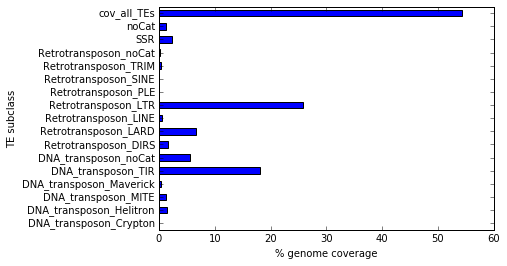

In [115]:
cov_per_class_df['%'].plot.barh()
plt.xlabel('% genome coverage')
plt.ylabel('TE subclass')

In [ ]:
#look at the same graph with blast only searches and see what we get. Consider that a different parsing of ideas might be
#more appropriate in this case

In [81]:
pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index')

,0
cov_all_TEs,45267875


In [74]:
cov_all_TEs

45267875

In [117]:
blast_codes.unique()

array(['ATCOPIA69A_I:ClassI:LTR:Copia', 'Copia-104_GM-I:ClassI:LTR:Copia',
       'Copia-137_AA-I:ClassI:LTR:Copia', ...,
       'Gypsy-3_CPu-I_3p:ClassI:LTR:Gypsy',
       'Gypsy-5_DSim-I_1p:ClassI:LTR:Gypsy',
       'Gypsy3_MH-I_1p:ClassI:LTR:Gypsy'], dtype=object)

In [ ]:
test = p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')].iloc[:,:-1]

test.head()

test[(test[0]== 'pcontig_000' )&(test[3] < 20000)]

test.sort_values([0,3],inplace =True)

df_REPET_noblast_classification.sort_values([0,1], inplace=True)

df_REPET_noblast_classification[df_REPET_noblast_classification.duplicated([0,1], keep=False )]

df_REPET_classification.drop_duplicates(subset=[0,1])

df_REPET_classification.sort_values([0,1], inplace=True)

df_REPET_classification_dup = df_REPET_classification[df_REPET_classification.duplicated(subset=[0,1], keep=False)]

p_repet_gff_filtered_2[(p_repet_gff_filtered_2[0] ==  'pcontig_000')&(p_repet_gff_filtered_2[3] < 14602)]

p_repet_gff_filtered_2[(p_repet_gff_filtered_2[0] ==  'pcontig_000')&(p_repet_gff_filtered_2[3] < 20000)].sort_values(3)

df_REPET_classification_dup.head(100)

## Below I am trying to sort out the cov files produced from bedfiles for each indiviudal TE element

In [205]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [241]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id(_id,_dict):
    repet_prefix = 'Pst_104E_v12_p_ctg.REPET.TE_level'
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id.split('_')[0] in list(code_dict.keys()):
        key = code_dict[_id.split('_')[0]].split(' ')[0]
        out_path = TE_path_dict[key]
    #everything without '_' at the end should be SSR
    elif '_' not in _id:
        out_path = TE_path_dict['SSR']
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    result = REPET_ID_bed.filter(id_filter, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    _len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
    _dict[_id] = _len
    #return pybedtools.BedTool(result.fn)

In [ ]:
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))

In [ ]:
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [226]:
_id = pd.read_csv(out_dir+'/'+genome+'.REPET.ID_column.gff', header=None, sep='\t')[8].unique()
REPET_ID_bed = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.ID_column.gff')
REPET_ID_bed = REPET_ID_bed.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.ID_column.bedobject')


In [ ]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.

jobs = []
bed_file = g
total_jobs = len(_id)
job_count = 0
manager = multiprocessing.Manager()
TE_cov_df  = manager.dict()
while job_count < total_jobs:
    while [j.is_alive() for j in jobs].count(True) > 30:
        time.sleep(15)
        print("Waiting for Subset_id_classification to finish!")
    if job_count +10 < total_jobs:
        for i in range(job_count, job_count+10):
            p = multiprocessing.Process(target=subset_id, args=([_id[i],TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
            
    else:
        for i in range(job_count, total_jobs+1):
            p = multiprocessing.Process(target=subset_id, args=([_id[i], TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done! Totaling %i"% (job_count))


In [250]:
for x in TE_cov_df.keys():
    print(x)

Copia-150_CCri-I:ClassI:LTR:Copia
Copia-29_MLP-I:ClassI:LTR:Copia
RLX-incomp_MCL9
DTX-incomp_MCL9
DTX-incomp-chim_MCL5
RLX-comp_MCL23
Copia-2_BM-I:ClassI:LTR:Copia
Copia-29_TC-I:ClassI:LTR:Copia
Copia-15_PPe-I:ClassI:LTR:Copia
A23
Copia-13_PTrit-I:ClassI:LTR:Copia
ATCOPIA69A_I:ClassI:LTR:Copia
Copia-54_MLP-I:ClassI:LTR:Copia
RYX-incomp-chim_MCL25
Copia-70_MLP-I:ClassI:LTR:Copia
Copia-2_PPa-I:ClassI:LTR:Copia
Copia-137_AA-I:ClassI:LTR:Copia
Copia-104_GM-I:ClassI:LTR:Copia
Copia-6_SMo-I:ClassI:LTR:Copia
Copia-2_PGr-I:ClassI:LTR:Copia
DTX-comp_MCL212


In [238]:
[j.is_alive() for j in jobs].count(True)

In [235]:
count = 0
while count < 10:
    count += 1
print(count)

In [ ]:
#this is REALLY slow for now. Would need to parallize this step. Look at the pool function of 
#multiprocessing

In [ ]:
[subset_id(x) for x in _id]

In [163]:
#this caputures all REPET cov files for each indiviual TE.
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir):
    #print(dirpath)
    #print(len(filenames))
    if len(filenames) == 0:  # empty folder
        continue
    cov_files = [dirpath +'/'+x for x in filenames if x.endswith('.cov') and 'classification' not in x ]
    for file in cov_files:
        class_cov_files.append(file)


In [166]:
filenames

['Pst_104E_v12_p_ctg.REPET.Gypsy-25_DPse-I:ClassI:LTR:Gypsy.gff',
 'Pst_104E_v12_p_ctg.REPET.I-2_DAn:ClassI:LINE:I.gff',
 'Pst_104E_v12_p_ctg.REPET.Gypsy-169_ZM-I_1p:ClassI:LTR:Gypsy.cov',
 'Pst_104E_v12_p_ctg.REPET.Gypsy-14_ADe-I:ClassI:LTR:Gypsy.cov',
 'Pst_104E_v12_p_ctg.REPET.DIRS-16_DR_2p:ClassI:DIRS:DIRS.cov',
 'Pst_104E_v12_p_ctg.REPET.Copia-6_Trm-I_1p:ClassI:LTR:Copia.gff',
 'Pst_104E_v12_p_ctg.REPET.Gypsy-70_SB-I_1p:ClassI:LTR:Gypsy.cov',
 'Pst_104E_v12_p_ctg.REPET.Gypsy-74_SB-I_2p:ClassI:LTR:Gypsy.gff',
 'Pst_104E_v12_p_ctg.REPET.Copia-13B_DR-I_1p:ClassI:LTR:Copia.cov',
 'Pst_104E_v12_p_ctg.REPET.Gypsy17-I_Dya:ClassI:LTR:Gypsy.gff',
 'Pst_104E_v12_p_ctg.REPET.Gypsy-2_PMar-I:ClassI:LTR:Gypsy.gff',
 'Pst_104E_v12_p_ctg.REPET.Copia-20_LU-I_1p:ClassI:LTR:Copia.gff',
 'Pst_104E_v12_p_ctg.REPET.Copia-3_LBS-I_2p:ClassI:LTR:Copia.cov',
 'Pst_104E_v12_p_ctg.REPET.Copia-22_CQ-I_1p:ClassI:LTR:Copia.cov',
 'Pst_104E_v12_p_ctg.REPET.Gypsy-27_DR1p:ClassI:LTR:Gypsy.gff',
 'Pst_104E_v12_p_ct

In [165]:
!pwd

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis


In [164]:
len(cov_files)

1590

In [ ]:

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_noblast_classification = pd.concat(df_list)

cov_per_class_noblast = df_REPET_noblast_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class_noblast = df_REPET_noblast_classification.groupby([0, 'Code long'])[1].count()

In [ ]:
full_path_list[0].replace('gff','cov')

In [ ]:
_test_id = _id[0:5]

In [ ]:
g = RE_id_gff.remove_invalid().saveas()

In [ ]:
[x for x in _test_id if '_' not in x]

In [ ]:
p_genome_file = 'Pst_104E_v12_p_ctg.genome_file'

In [ ]:
all_cov_RE = g.genome_coverage(dz=True,g=p_genome_file)

all_cov_RE.saveas('Pst_104E_v12_p_ctg.REPET.ID_column.cov')

In [ ]:
p_repet_gff_filtered[1].unique()

In [ ]:
[x for x in p_repet_gff_filtered_2[(p_repet_gff_filtered_2[1] == 'Pst79p_anno_REPET_TE')  ][8].unique() if '_' not in x]

In [ ]:
[x for x in p_repet_gff_filtered_2[(p_repet_gff_filtered_2[1] == 'Pst79p_anno_REPET_tblastx') | (p_repet_gff_filtered_2[1] == 'Pst79p_anno_REPET_blastx') ][8].unique() if '_' not in x]

In [ ]:
p_repet_gff[p_repet_gff[8].str.contains('Copia6-VV_I_')][8]